# Plot

In [ ]:
from katlas.core import *
from katlas.plot import *
from katlas.feature import *
import pandas as pd

## Get data

In [ ]:
df = Data.get_ks_dataset()

Remove duplicates based on uppercase sequences

In [ ]:
SEQ_COL='substrate'

In [ ]:
df['SUB'] = df[SEQ_COL].str.upper()
df = df.drop_duplicates(subset='SUB').reset_index(drop=True)

## Transformer unsupervised

In [ ]:
import random
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import umap.umap_ as umap

from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)

In [ ]:
model_name = "Rostlab/prot_bert"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
tokenizer.get_vocab()

{'G': 7,
 'S': 10,
 'I': 11,
 'F': 19,
 'O': 29,
 'A': 6,
 '[SEP]': 3,
 'Y': 20,
 'X': 25,
 'V': 8,
 '[MASK]': 4,
 'U': 26,
 'M': 21,
 'P': 16,
 'R': 13,
 '[CLS]': 2,
 'E': 9,
 '[UNK]': 1,
 '[PAD]': 0,
 'L': 5,
 'T': 15,
 'K': 12,
 'C': 23,
 'N': 17,
 'B': 27,
 'W': 24,
 'Z': 28,
 'D': 14,
 'H': 22,
 'Q': 18}

In [ ]:
seq='AEGLRPAsPLGLTQE_'


In [ ]:
seq.replace('_','[PAD]')

'AEGLRPAsPLGLTQE[PAD]'

In [ ]:
tks = tokenizer.tokenize(' '.join(a))

In [ ]:
tokenizer.convert_tokens_to_ids(tks)

[6, 9, 7, 5, 13, 16, 6, 30, 16, 5, 7, 5, 15, 18, 9]

In [ ]:
# Add new tokens for phosphorylated residues.
new_tokens = ["s", "t", "y"]
num_added = tokenizer.add_tokens(new_tokens)
print(f"Added {num_added} new tokens.")

Added 3 new tokens.


In [ ]:
tokenizer.get_vocab()

{'L': 5,
 'X': 25,
 'H': 22,
 'F': 19,
 'R': 13,
 'I': 11,
 '[SEP]': 3,
 'P': 16,
 'Q': 18,
 'G': 7,
 'C': 23,
 'B': 27,
 's': 30,
 'T': 15,
 '[CLS]': 2,
 'N': 17,
 'M': 21,
 'D': 14,
 'W': 24,
 '[PAD]': 0,
 'Z': 28,
 '[UNK]': 1,
 '_': 33,
 'K': 12,
 'V': 8,
 'U': 26,
 'A': 6,
 'S': 10,
 'O': 29,
 'Y': 20,
 'y': 32,
 'E': 9,
 't': 31,
 '[MASK]': 4}

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(34, 1024)

In [ ]:
class ProteinDataset(Dataset):
    def __init__(self, sequences, tokenizer):
        """
        sequences: list of protein sequences (strings) that are already padded with '_'
        tokenizer: a HuggingFace tokenizer for your protein model
        """
        self.sequences = sequences
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        seq = ' '.join(seq).replace('_','[PAD]')
        tokenized = self.tokenizer(seq, 
                                   add_special_tokens=True, 
                                   padding=False, 
                                   truncation=False, 
                                   return_tensors="pt")
        # Squeeze to remove the batch dimension.
        return {"input_ids": tokenized["input_ids"].squeeze(0)}

In [ ]:
a = 'AEGLRPAstyPLGLTQE__'

In [ ]:
seq = ' '.join(a).replace('_','[PAD]')

In [ ]:
tokenizer.tokenize(seq)

['A',
 'E',
 'G',
 'L',
 'R',
 'P',
 'A',
 's',
 't',
 'y',
 'P',
 'L',
 'G',
 'L',
 'T',
 'Q',
 'E',
 '[PAD]',
 '[PAD]']

In [ ]:
dataset = ProteinDataset(df.substrate.tolist(), tokenizer)

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [ ]:
training_args = TrainingArguments(
    output_dir="./protein_transformer_results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=50,
    logging_steps=20,
    prediction_loss_only=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

In [ ]:
trainer.train()

Step,Training Loss
20,3.248300
40,3.046500
60,2.975800
80,3.069900
100,2.989000
120,3.023100
140,3.052500
160,3.051400
180,3.053300
200,3.010100


OSError: [Errno 28] No space left on device: './protein_transformer_results/checkpoint-3750'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

In [ ]:
def get_sequence_embedding(sequence, max_length=512):
    # Tokenize and pad the sequence.
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    with torch.no_grad():
        # For ProtBERT, the encoder is available as model.bert
        outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # [1, seq_len, hidden_size]
    # Average pooling over non-padded tokens.
    mask = attention_mask.unsqueeze(-1).float()
    summed = (hidden_states * mask).sum(dim=1)
    avg_embedding = summed / mask.sum(dim=1).clamp(min=1)
    return avg_embedding.squeeze(0).cpu().numpy()

In [ ]:
embeddings = []
for seq in dummy_sequences:
    emb = get_sequence_embedding(seq)
    embeddings.append(emb)
embeddings = np.array(embeddings)

In [ ]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, cmap="Spectral")
plt.title("UMAP Projection of ProtBERT Protein Embeddings")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar()
plt.show()

## Co-occurance

In [ ]:
import numpy as np
import pandas as pd
from itertools import product

In [ ]:
sequences = df['substrate'].tolist()

# Define amino acids
amino_acids = sorted(set("".join(sequences)))  # Standard 20 amino acids
seq_length = len(sequences[0])  # Assuming all sequences have same length

# Define feature types
n_gram_size = 2  # Adjust for dipeptides, tripeptides, etc.
max_gap_size = 3  # Consider up to this many gaps
all_features = set()

# Generate all possible features
# 1. N-grams (adjacent)
n_grams = ["".join(p) for p in product(amino_acids, repeat=n_gram_size)]
all_features.update(n_grams)

# 2. Gapped k-mers (gaps up to max_gap_size)
for gap in range(1, max_gap_size + 1):
    for p in product(amino_acids, repeat=2):
        all_features.add(f"{p[0]}_{gap}_{p[1]}")  # Example: "S_3_A"

# 3. Position-based encoding
for pos in range(seq_length):
    for aa in amino_acids:
        all_features.add(f"{aa}_pos{pos}")  # Example: "A_pos3"

# Convert to sorted list for indexing
all_features = sorted(all_features)
feature_index = {feat: i for i, feat in enumerate(all_features)}

# Initialize feature matrix
feature_matrix = np.zeros((len(sequences), len(all_features)))

# Encode sequences
for seq_idx, seq in enumerate(sequences):
    # 1. Encode n-grams
    for i in range(seq_length - n_gram_size + 1):
        n_gram = seq[i:i+n_gram_size]
        if n_gram in feature_index:
            feature_matrix[seq_idx, feature_index[n_gram]] += 1

    # 2. Encode gapped k-mers
    for gap in range(1, max_gap_size + 1):
        for i in range(seq_length - gap - 1):
            gapped_kmer = f"{seq[i]}_{gap}_{seq[i+gap+1]}"
            if gapped_kmer in feature_index:
                feature_matrix[seq_idx, feature_index[gapped_kmer]] += 1

    # 3. Encode position-based
    for pos, aa in enumerate(seq):
        pos_feature = f"{aa}_pos{pos}"
        if pos_feature in feature_index:
            feature_matrix[seq_idx, feature_index[pos_feature]] = 1  # Binary one-hot

# Convert to DataFrame
feature_df = pd.DataFrame(feature_matrix, columns=all_features)

In [ ]:
st = feature_df.sum().sort_values()

In [ ]:
st.shape

(2664,)

In [ ]:
col = st[st>50].index

In [ ]:
feature = feature_df[col]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/logomaker/../umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


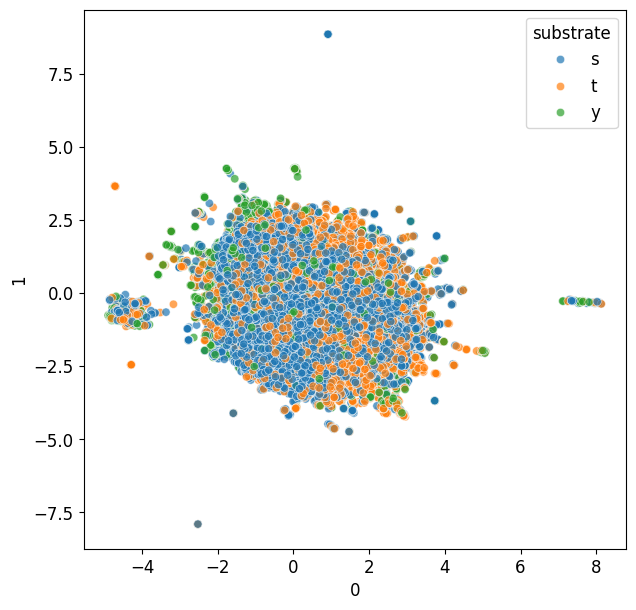

In [ ]:
# Normalize features
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature.values)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_embeddings = umap_model.fit_transform(feature_matrix_scaled)

plot_2d(pd.DataFrame(umap_embeddings),hue=df.substrate.str[7])

In [ ]:
len(aa_pairs)

576

In [ ]:
sequences = df['substrate'].tolist()

# Get unique amino acids
amino_acids = sorted(set("".join(sequences)))  # Assuming standard 20 amino acids
aa_pairs = ["".join(p) for p in product(amino_acids, repeat=2)]

# Initialize co-occurrence matrix
co_occurrence = {pair: 0 for pair in aa_pairs}

# Compute pairwise co-occurrence across all sequences
seq_length = len(sequences[0])  # Assuming fixed length
for seq in sequences:
    for i in range(seq_length - 1):  # Co-occurrence of adjacent AA
        pair = seq[i] + seq[i + 1]
        if pair in co_occurrence:
            co_occurrence[pair] += 1

# Normalize by total occurrences
total_pairs = sum(co_occurrence.values())
if total_pairs > 0:
    for pair in co_occurrence:
        co_occurrence[pair] /= total_pairs

# Convert to DataFrame (one-hot style)
co_occurrence_df = pd.DataFrame([co_occurrence])

In [ ]:
co = co_occurrence_df.T[0]

In [ ]:
co.shape

(576,)

In [ ]:
co

AA    0.005328
AC    0.000688
AD    0.003357
AE    0.004739
AF    0.001541
        ...   
yY    0.000119
y_    0.000093
ys    0.001970
yt    0.001161
yy    0.001496
Name: 0, Length: 576, dtype: float64

## K-mer

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from collections import Counter
from sklearn.preprocessing import StandardScaler

def extract_kmers(peptides, k):
    """Generate k-mer frequency feature vectors from a list of peptide sequences."""
    all_kmers = []
    feature_vectors = []

    # Collect all k-mers to create a global vocabulary
    for peptide in peptides:
        kmers = [peptide[i:i+k] for i in range(len(peptide) - k + 1)]
        all_kmers.extend(kmers)

    unique_kmers = list(set(all_kmers))  # Unique k-mers as features
    kmer_dict = {kmer: i for i, kmer in enumerate(unique_kmers)}

    # Generate feature vectors
    for peptide in peptides:
        kmers = [peptide[i:i+k] for i in range(len(peptide) - k + 1)]
        kmer_counts = Counter(kmers)
        vector = np.zeros(len(unique_kmers))

        for kmer, count in kmer_counts.items():
            vector[kmer_dict[kmer]] = count

        feature_vectors.append(vector)

    return np.array(feature_vectors), unique_kmers

In [ ]:
peptides = df.substrate.tolist()

In [ ]:
feature_matrix, kmer_labels = extract_kmers(peptides, 1)

In [ ]:
feature_matrix.shape

(30644, 24)

In [ ]:
feature = pd.DataFrame(feature_matrix)

In [ ]:
feature.sum().sort_values()

13     3043.0
22     3064.0
7      4531.0
10     5601.0
0      7103.0
15     8655.0
11    12330.0
4     12557.0
12    13728.0
17    15595.0
2     15644.0
9     15786.0
16    19492.0
3     20461.0
6     22756.0
1     26067.0
14    28060.0
23    28974.0
19    29204.0
21    29885.0
5     30835.0
18    33524.0
20    35948.0
8     36817.0
dtype: float64

In [ ]:
one_hot  = pd.get_dummies(df.substrate.str[7]).astype(int)

In [ ]:
feature = pd.concat([feature,one_hot],axis=1)

In [ ]:
st = feature.sum()

In [ ]:
col = st[st>500].index

In [ ]:
feature =feature[col]

In [ ]:
# Normalize features
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature.values)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='euclidean', random_state=42)
umap_embeddings = umap_model.fit_transform(feature_matrix_scaled)

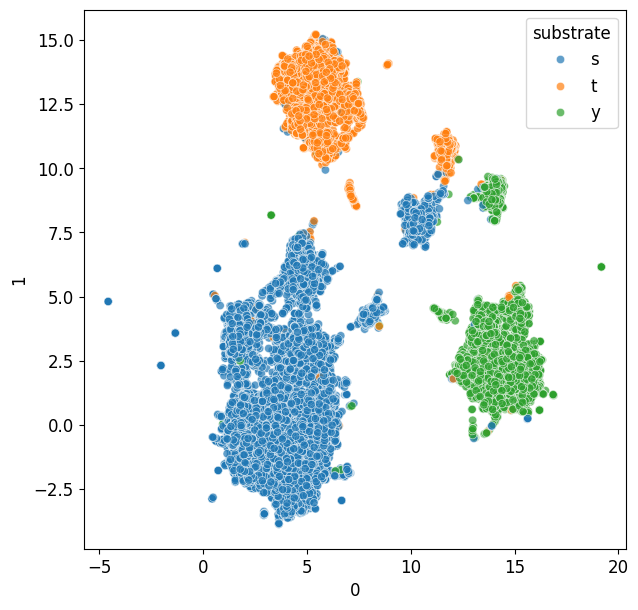

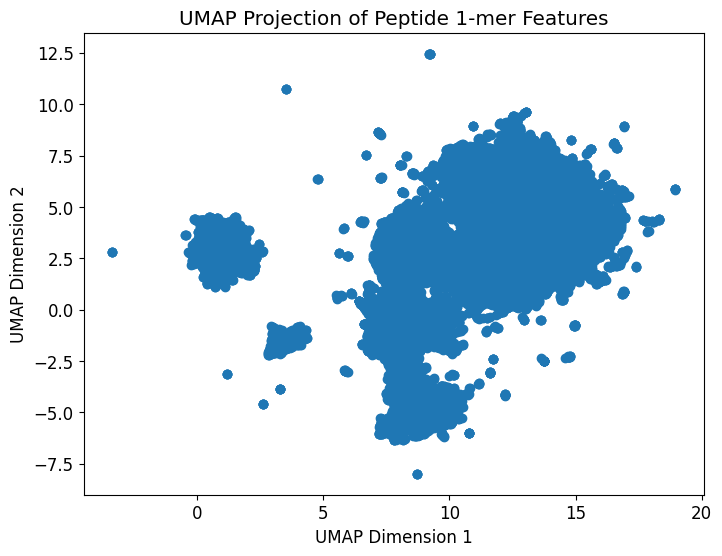

In [ ]:






# Visualize the result
plt.figure(figsize=(8,6))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1])
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title(f"UMAP Projection of Peptide {1}-mer Features")
plt.show()

## One-hot encode

In [ ]:
onehot = onehot_encode(df[SEQ_COL])
onehot

,x0_A,x0_C,x0_D,x0_E,x0_F,x0_G,x0_H,x0_I,x0_K,x0_L,x0_M,x0_N,x0_P,x0_Q,x0_R,x0_S,x0_T,x0_V,x0_W,x0_Y,x0__,x0_s,x0_t,x0_y,x1_A,x1_C,x1_D,x1_E,x1_F,x1_G,x1_H,x1_I,x1_K,x1_L,x1_M,x1_N,x1_P,x1_Q,x1_R,x1_S,x1_T,x1_V,x1_W,x1_Y,x1__,x1_s,x1_t,x1_y,x2_A,x2_C,x2_D,x2_E,x2_F,x2_G,x2_H,x2_I,x2_K,x2_L,x2_M,x2_N,x2_P,x2_Q,x2_R,x2_S,x2_T,x2_V,x2_W,x2_Y,x2__,x2_s,x2_t,x2_y,x3_A,x3_C,x3_D,x3_E,x3_F,x3_G,x3_H,x3_I,x3_K,x3_L,x3_M,x3_N,x3_P,x3_Q,x3_R,x3_S,x3_T,x3_V,x3_W,x3_Y,x3__,x3_s,x3_t,x3_y,x4_A,x4_C,x4_D,x4_E,x4_F,x4_G,x4_H,x4_I,x4_K,x4_L,x4_M,x4_N,x4_P,x4_Q,x4_R,x4_S,x4_T,x4_V,x4_W,x4_Y,x4__,x4_s,x4_t,x4_y,x5_A,x5_C,x5_D,x5_E,x5_F,x5_G,x5_H,x5_I,x5_K,x5_L,x5_M,x5_N,x5_P,x5_Q,x5_R,x5_S,x5_T,x5_V,x5_W,x5_Y,x5__,x5_s,x5_t,x5_y,x6_A,x6_C,x6_D,x6_E,x6_F,x6_G,x6_H,x6_I,x6_K,x6_L,x6_M,x6_N,x6_P,x6_Q,x6_R,x6_S,x6_T,x6_V,x6_W,x6_Y,x6__,x6_s,x6_t,x6_y,x7_s,x7_t,x7_y,x8_A,x8_C,x8_D,x8_E,x8_F,x8_G,x8_H,x8_I,x8_K,x8_L,x8_M,x8_N,x8_P,x8_Q,x8_R,x8_S,x8_T,x8_V,x8_W,x8_Y,x8__,x8_s,x8_t,x8_y,x9_A,x9_C,x9_D,x9_E,x9_F,x9_G,x9_H,x9_I,x9_K,x9_L,x9_M,x9_N,x9_P,x9_Q,x9_R,x9_S,x9_T,x9_V,x9_W,x9_Y,x9__,x9_s,x9_t,x9_y,x10_A,x10_C,x10_D,x10_E,x10_F,x10_G,x10_H,x10_I,x10_K,x10_L,x10_M,x10_N,x10_P,x10_Q,x10_R,x10_S,x10_T,x10_V,x10_W,x10_Y,x10__,x10_s,x10_t,x10_y,x11_A,x11_C,x11_D,x11_E,x11_F,x11_G,x11_H,x11_I,x11_K,x11_L,x11_M,x11_N,x11_P,x11_Q,x11_R,x11_S,x11_T,x11_V,x11_W,x11_Y,x11__,x11_s,x11_t,x11_y,x12_A,x12_C,x12_D,x12_E,x12_F,x12_G,x12_H,x12_I,x12_K,x12_L,x12_M,x12_N,x12_P,x12_Q,x12_R,x12_S,x12_T,x12_V,x12_W,x12_Y,x12__,x12_s,x12_t,x12_y,x13_A,x13_C,x13_D,x13_E,x13_F,x13_G,x13_H,x13_I,x13_K,x13_L,x13_M,x13_N,x13_P,x13_Q,x13_R,x13_S,x13_T,x13_V,x13_W,x13_Y,x13__,x13_s,x13_t,x13_y,x14_A,x14_C,x14_D,x14_E,x14_F,x14_G,x14_H,x14_I,x14_K,x14_L,x14_M,x14_N,x14_P,x14_Q,x14_R,x14_S,x14_T,x14_V,x14_W,x14_Y,x14__,x14_s,x14_t,x14_y
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
onhot_embed=reduce_feature(onehot,'umap')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/logomaker/../umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


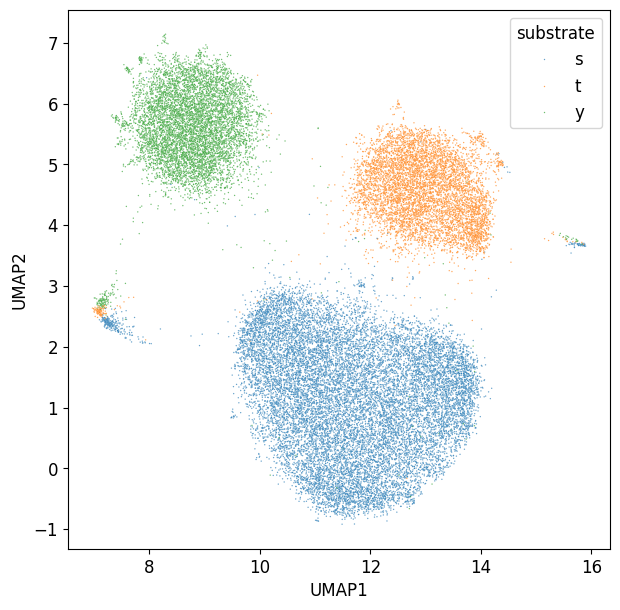

In [ ]:
plot_2d(onhot_embed,s=1,hue=df[SEQ_COL].str[7])

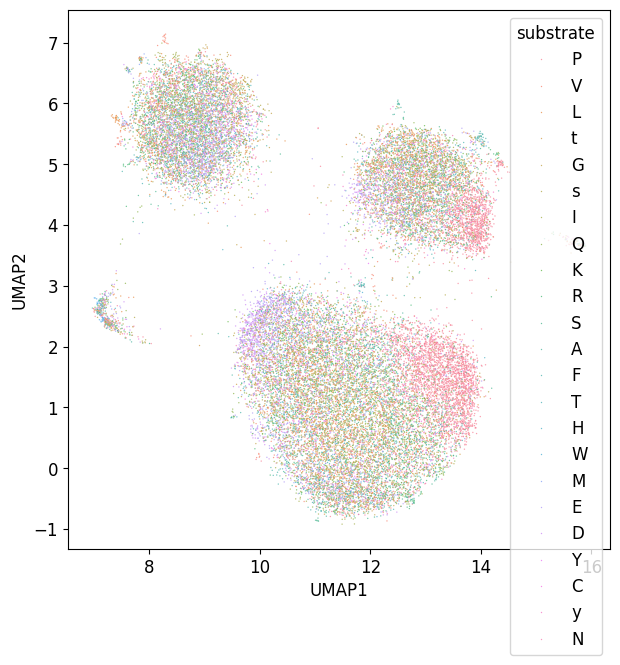

In [ ]:
plot_2d(onhot_embed,s=1,hue=df[SEQ_COL].str[8])

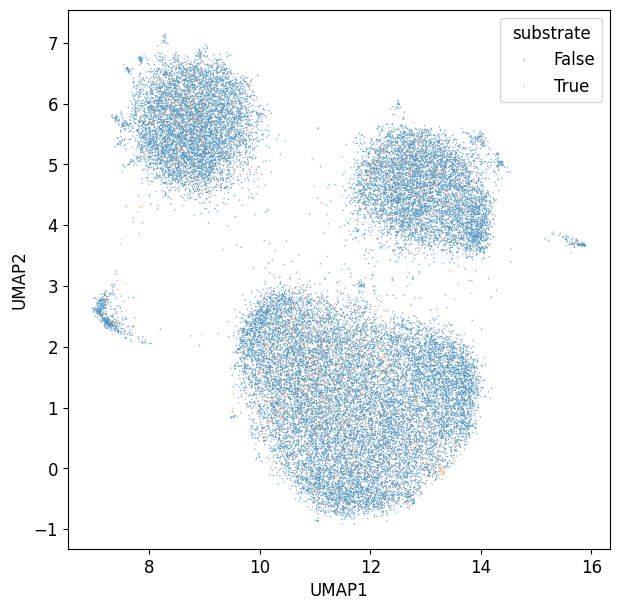

In [ ]:
plot_2d(onhot_embed,s=1,hue=df[SEQ_COL].str[8]=='Q')

Not very much separation

## Physicochemical encoded

In [ ]:
aa = Data.get_aa_info().iloc[:-2,:]

In [ ]:
feat = get_rdkit_df(aa,'SMILES')

removing columns: {'Chi0', 'fr_C_O_noCOO', 'Asphericity', 'fr_isothiocyan', 'fr_ketone', 'LabuteASA', 'HeavyAtomCount', 'fr_para_hydroxylation', 'fr_amidine', 'fr_barbitur', 'MaxEStateIndex', 'NumAliphaticRings', 'HeavyAtomMolWt', 'fr_Al_OH_noTert', 'NumSaturatedCarbocycles', 'SlogP_VSA7', 'fr_phos_ester', 'VSA_EState9', 'fr_azide', 'NumSaturatedHeterocycles', 'fr_thiophene', 'fr_Ar_COO', 'fr_bicyclic', 'fr_COO', 'fr_nitro', 'fr_ether', 'fr_imidazole', 'fr_oxime', 'fr_nitroso', 'fr_morpholine', 'fr_piperdine', 'fr_halogen', 'fr_epoxide', 'fr_sulfone', 'fr_methoxy', 'SlogP_VSA11', 'fr_N_O', 'fr_Ndealkylation1', 'fr_COO2', 'fr_oxazole', 'fr_nitro_arom_nonortho', 'fr_HOCCN', 'NumSpiroAtoms', 'fr_piperzine', 'fr_phenol', 'fr_ketone_Topliss', 'fr_furan', 'fr_prisulfonamd', 'VSA_EState1', 'fr_benzodiazepine', 'fr_Ndealkylation2', 'fr_sulfonamd', 'SlogP_VSA6', 'PMI3', 'fr_Ar_NH', 'fr_urea', 'fr_isocyan', 'fr_azo', 'MaxPartialCharge', 'MinAbsPartialCharge', 'SMR_VSA8', 'fr_phenol_noOrthoHbond'

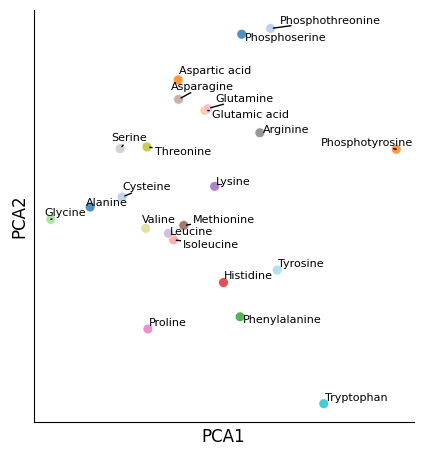

In [ ]:
plot_cluster(feat, name_list = aa.Name.tolist(), hue = 'aa', method = 'pca')

In [ ]:
dist_df,sim_df = get_similarity(feat)

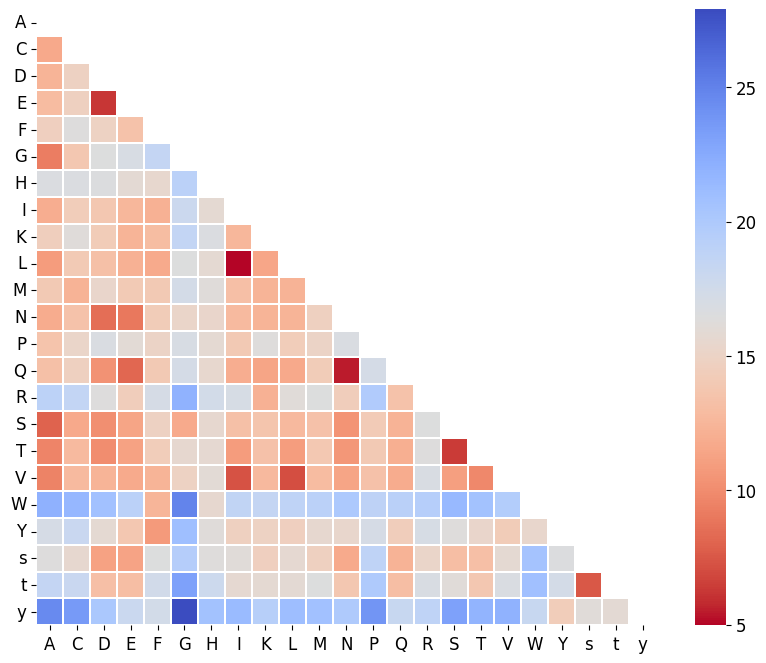

In [ ]:
plot_matrix(dist_df,inverse_color=True)

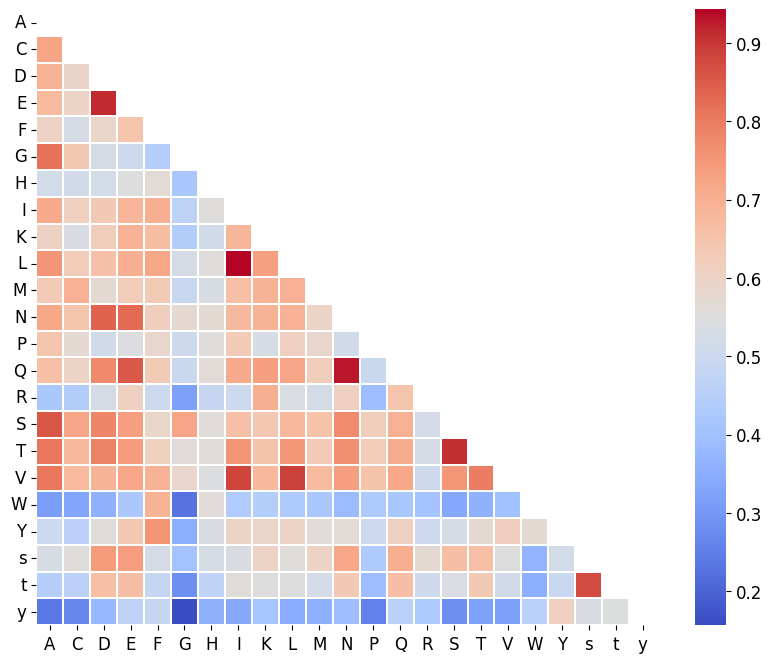

In [ ]:
plot_matrix(sim_df)

In [ ]:
feat.shape

(23, 116)

In [ ]:
def encode_seq(seq, encoder):
    vec = []
    feature_length = len(encoder.iloc[0])  # Get the length of feature vectors

    for aa in seq:
        if aa.upper() in encoder.index:
            vec.extend(encoder.loc[aa.upper()].tolist())
        else:
            vec.extend([0] * feature_length)  # Append zeros if AA is missing
    return vec

In [ ]:
check_seq_df(df, SEQ_COL)

  0%|          | 0/30644 [00:00<?, ?it/s]

0        AEGLRPAsPLGLTQE
1        GGGAGPVsPQHHELT
2        LRGNVVPsPLPtRRt
3        GPMRRSKsPADSANG
4        PERsQEEsPPGSTKR
              ...       
30639    GGGEGNVsQVGRVWP
30640    SSYRALIsAFSRLTR
30641    MDRSKRNsIAGFPPR
30642    FKVRHRAsGQVMALK
30643    YEKDGDEsSPILTsF
Name: substrate, Length: 30644, dtype: object

In [ ]:
encoded = df['substrate'].progress_apply(lambda x: encode_seq(x,feat))

  0%|          | 0/30644 [00:00<?, ?it/s]

In [ ]:
encoded = encoded.apply(pd.Series)

In [ ]:
embedding_df=reduce_feature(encoded,'umap')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/logomaker/../umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


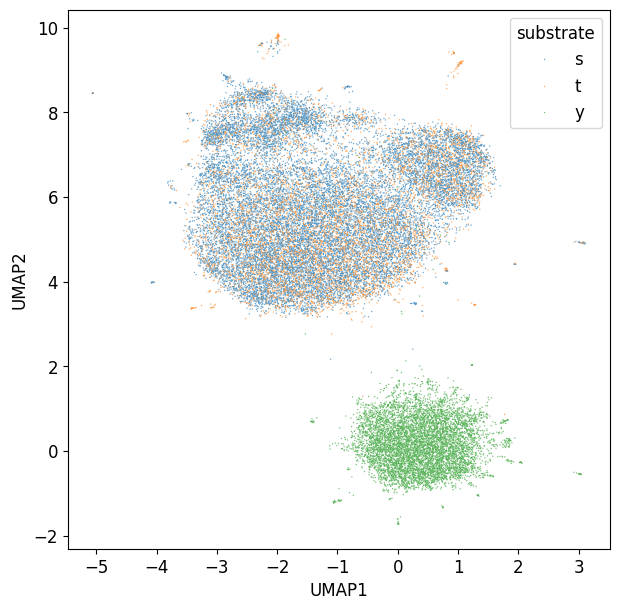

In [ ]:
plot_2d(embedding_df,s=1,hue=df[SEQ_COL].str[7])

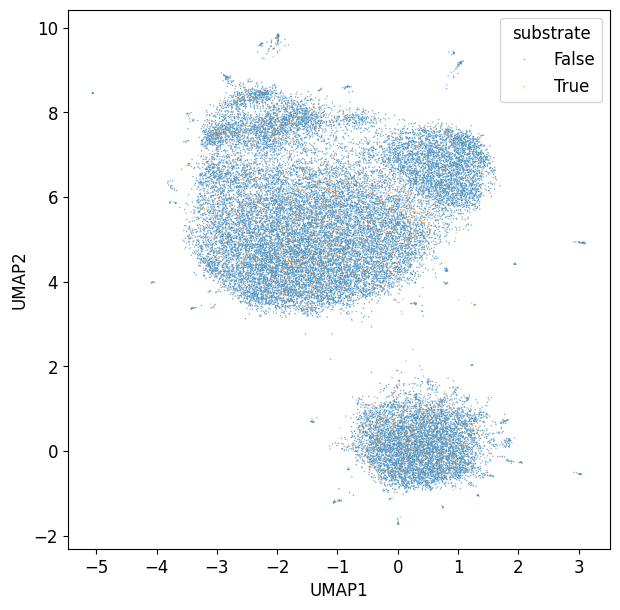

In [ ]:
plot_2d(embedding_df,s=1,hue=df[SEQ_COL].str[8]=="A")

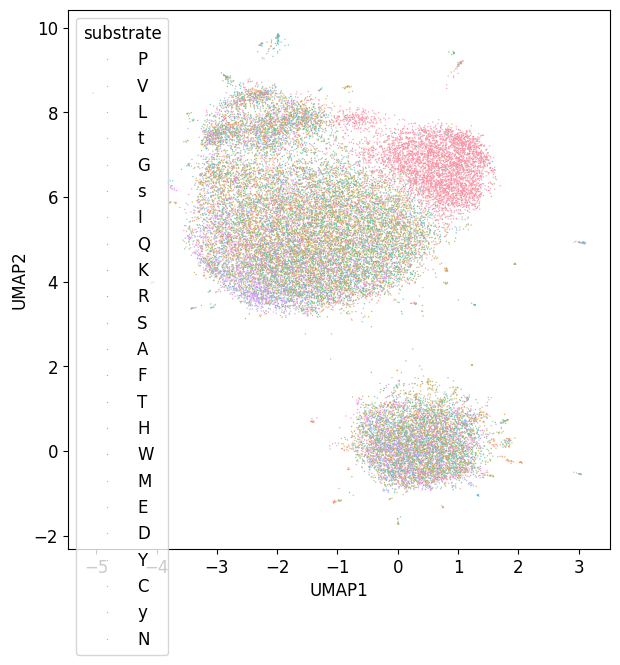

In [ ]:
plot_2d(embedding_df,s=1,hue=df[SEQ_COL].str[8])

A little bit more seperation in terms of +1P group

## Onehot + physicochemical

In [ ]:
comb = pd.concat([onehot,encoded],axis=1)

In [ ]:
comb_emb=reduce_feature(comb,'umap')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/logomaker/../umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


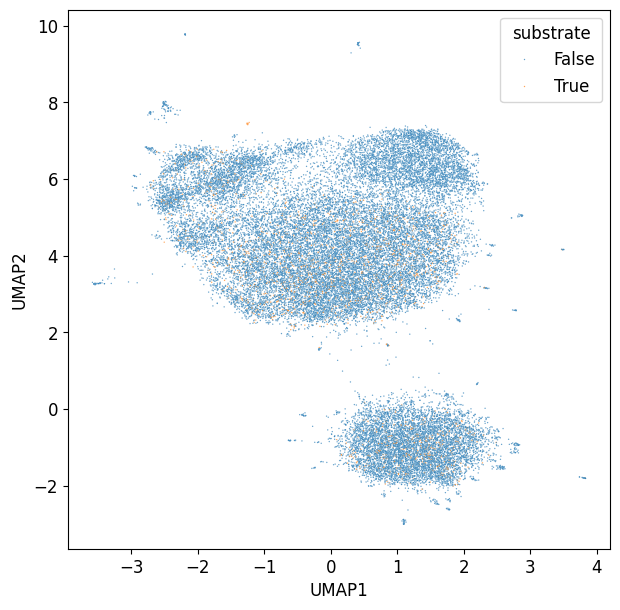

In [ ]:
plot_2d(comb_emb,s=1,hue=df[SEQ_COL].str[8]=="Q")

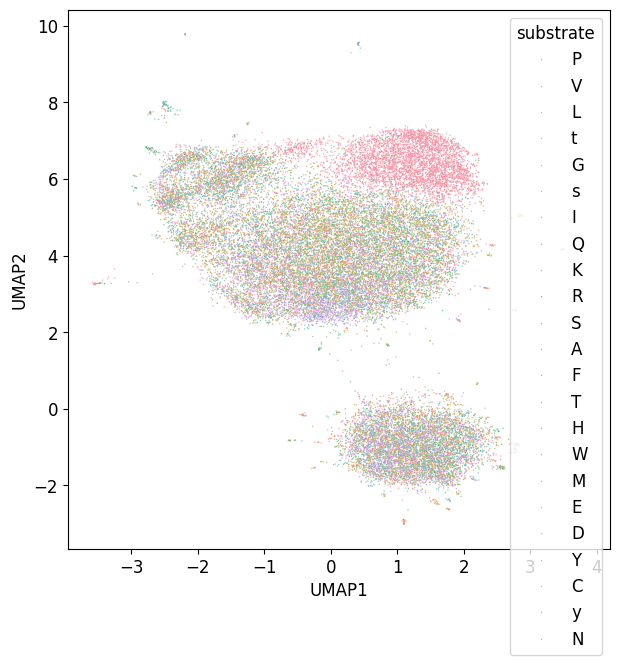

In [ ]:
plot_2d(comb_emb,s=1,hue=df[SEQ_COL].str[8])

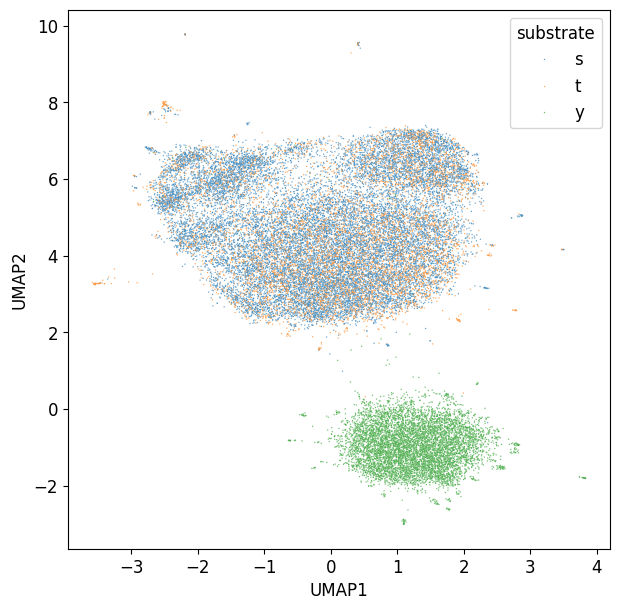

In [ ]:
plot_2d(comb_emb,s=1,hue=df[SEQ_COL].str[7])

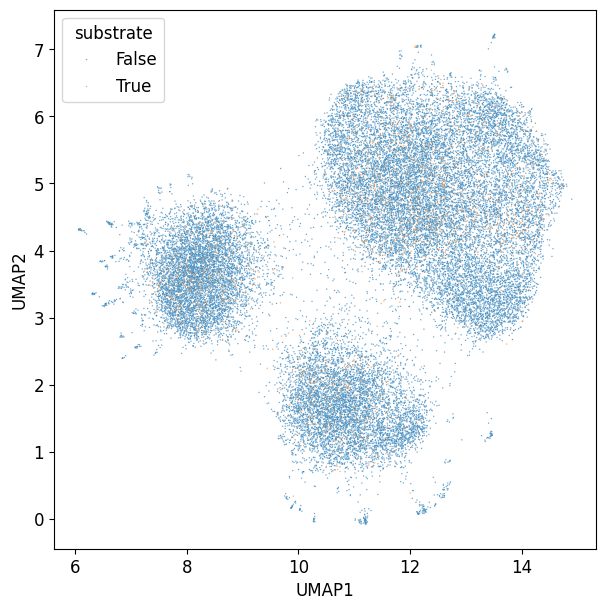

In [ ]:
plot_2d(onehot_pos_emb,s=1,hue=df[SEQ_COL].str[8]=="Q")

No much difference with the physiochemical alone

## Transformer based

## Plot interactions: onehot + kinase features

use onehot or kinase feature

In [ ]:
df = Data.get_ks_dataset()

In [ ]:
df.kinase_paper = df.kinase_paper.replace({'PDK3':'PDHK3'})

In [ ]:
df = df.dropna(subset='kinase_paper')

In [ ]:
df = df.drop_duplicates(subset=['substrate','kinase_paper']).reset_index(drop=True)

In [ ]:
info = Data.get_kinase_info()

In [ ]:
df.kinase_paper.isin(info.kinase).value_counts()

kinase_paper
True    168331
Name: count, dtype: int64

In [ ]:
info.pseudo.value_counts()

pseudo
0             462
1              57
possible        3
pseudogene      1
Name: count, dtype: int64

In [ ]:
pseudo = info[info.pseudo!='0']

In [ ]:
df.kinase_paper.isin(pseudo.kinase).value_counts()

kinase_paper
False    165393
True       2938
Name: count, dtype: int64

In [ ]:
pseudo

,kinase,ID_coral,uniprot,ID_HGNC,group,family,subfamily_coral,subfamily,in_ST_paper,in_Tyr_paper,in_cddm,pseudo,pspa_category_small,pspa_category_big,cddm_big,cddm_small,length,human_uniprot_sequence,kinasecom_domain,nucleus,cytosol,cytoskeleton,plasma membrane,mitochondrion,Golgi apparatus,endoplasmic reticulum,vesicle,centrosome,aggresome,main_location
25,NPR1,ANPa,P16066,NPR1,RGC,RGC,None,RGC,0,0,0,1,None,None,NaN,NaN,1061,MPGPRRPAGSRLRLLLLLLLPPLLLLLRGSHAGNLTVAVVLPLANTSYPWSWARVGPAVELALAQVKARPDLLPGWTVRTVLGSSENALGVCSDTAAPLAAVDLKWEHNPAVFLGPGCVYAAAPVGRFTAHWRVPLLTAGAPALGFGVKDEYALTTRAGPSYAKLGDFVAALHRRLGWERQALMLYAYRPGDEEHCFFLVEGLFMRVRDRLNITVDHLEFAEDDLSHYTRLLRTMPRKGRVIYICSSPDAFRTLMLLALEAGLCGEDYVFFHLDIFGQSLQGGQGPAPRRPWERGDGQDVSARQAFQAAKIITYKDPDNPEYLEFLKQLKHLAYEQFNFTMEDGLVNTIPASFHDGLLLYIQAVTETLAHGGTVTDGENITQRMWNRSFQGVTGYLKIDSSGDRETDFSLWDMDPENGAFRVVLNYNGTSQELVAVSGRKLNWPLGYPPPDIPKCGFDNEDPACNQDHLSTLEVLALVGSLSLLGILIVSFFIYRKMQLEKELASELWRVRWEDVEPSSLERHLRSAGSRLTLSGRGSNYGSLLTTEGQFQVFAKTAYYKGNLVAVKRVNRKRIELTRKVLFELKHMRDVQNEHLT...,GSRLTLSGRGSNYGSLLTTEGQFQVFAKTAYYKGNLVAVKRVNRKRIELTRKVLFELKHMRDVQNEHLTRFVGACTDPPNICILTEYCPRGSLQDILENESITLDWMFRYSLTNDIVKGMLFLHNGAICSHGNLKSSNCVVDGRFVLKITDYGLESFRDLDPEQGHTVYAKKLWTAPELLRMASPPVRGSQAGDVYSFGIILQEIALRSGVFHVEGLDLSPKEIIERVTRGEQPPFRPSLALQSHLEELGLLMQRCWAEDPQERPPFQQIRLTLRK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
26,NPR2,ANPb,P20594,NPR2,RGC,RGC,None,RGC,0,0,0,1,None,None,NaN,NaN,1047,MALPSLLLLVAALAGGVRPPGARNLTLAVVLPEHNLSYAWAWPRVGPAVALAVEALGRALPVDLRFVSSELEGACSEYLAPLSAVDLKLYHDPDLLLGPGCVYPAASVARFASHWRLPLLTAGAVASGFSAKNDHYRTLVRTGPSAPKLGEFVVTLHGHFNWTARAALLYLDARTDDRPHYFTIEGVFEALQGSNLSVQHQVYAREPGGPEQATHFIRANGRIVYICGPLEMLHEILLQAQRENLTNGDYVFFYLDVFGESLRAGPTRATGRPWQDNRTREQAQALREAFQTVLVITYREPPNPEYQEFQNRLLIRAREDFGVELGPSLMNLIAGCFYDGILLYAEVLNETIQEGGTREDGLRIVEKMQGRRYHGVTGLVVMDKNNDRETDFVLWAMGDLDSGDFQPAAHYSGAEKQIWWTGRPIPWVKGAPPSDNPPCAFDLDDPSCDKTPLSTLAIVALGTGITFIMFGVSSFLIFRKLMLEKELASMLWRIRWEELQFGNSERYHKGAGSRLTLSLRGSSYGSLMTAHGKYQIFANTGHFKGNVVAIKHVNKKRIELTRQVLFELKHMRDVQFNHLTRFIGACIDPPNICIVT...,GSRLTLSLRGSSYGSLMTAHGKYQIFANTGHFKGNVVAIKHVNKKRIELTRQVLFELKHMRDVQFNHLTRFIGACIDPPNICIVTEYCPRGSLQDILENDSINLDWMFRYSLINDLVKGMAFLHNSIISSHGSLKSSNCVVDSRFVLKITDYGLASFRSTAEPDDSHALYAKKLWTAPELLSGNPLPTTGMQKADVYSFGIILQEIALRSGPFYLEGLDLSPKEIVQKVRNGQRPYFRPSIDRTQLNEELVLLMERCWAQDPAERPDFGQIKGFIRR,NaN,2.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,endoplasmic reticulum
53,BUB1B,BUBR1,O60566,BUB1B,Other,BUB,None,BUB,0,0,1,possible,None,None,5.0,47.0,1050,MAAVKKEGGALSEAMSLEGDEWELSKENVQPLRQGRIMSTLQGALAQESACNNTLQQQKRAFEYEIRFYTGNDPLDVWDRYISWTEQNYPQGGKESNMSTLLERAVEALQGEKRYYSDPRFLNLWLKLGRLCNEPLDMYSYLHNQGIGVSLAQFYISWAEEYEARENFRKADAIFQEGIQQKAEPLERLQSQHRQFQARVSRQTLLALEKEEEEEVFESSVPQRSTLAELKSKGKKTARAPIIRVGGALKAPSQNRGLQNPFPQQMQNNSRITVFDENADEASTAELSKPTVQPWIAPPMPRAKENELQAGPWNTGRSLEHRPRGNTASLIAVPAVLPSFTPYVEETARQPVMTPCKIEPSINHILSTRKPGKEEGDPLQRVQSHQQASEEKKEKMMYCKEKIYAGVGEFSFEEIRAEVFRKKLKEQREAELLTSAEKRAEMQKQIEEMEKKLKEIQTTQQERTGDQQEETMPTKETTKLQIASESQKIPGMTLSSSVCQVNCCARETSLAENIWQEQPHSKGPSVPFSIFDEFLLSEKKNKSPPADPPRVLAQRRPLAVLKTSESITSNEDVSPDVCDEFTGIEPLSEDAIITGF...,LEIEKEIELGNEDYCIKREYLICEDYKLFWVAPRNSAELTVIKVSSQPVPWDFYINLKLKERLNEDFDHFCSCYQYQDGCIVWHQYINCFTLQDLLQHSEYITHEITVLIIYNLLTIVEMLHKAEIVHGDLSPRCLILRNRIHDPYDCNKNNQALKIVDFSYSVDLRVQLDVFTLSGFRTVQILEGQKILANCSSPYQVDLFGIADLAHLLLFKEHLQVFWDGSFWKLSQNISELKDGELWNKFFVRILNANDEATVSVLGELAA,NaN,7.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,cytosol
67,PTK7,CCK4,Q13308,PTK7,TK,CCK4,None,CCK4,0,0,0,1,None,None,NaN,NaN,1070,MGAARGSPARPRRLPLLSVLLLPLLGGTQTAIVFIKQPSSQDALQGRRALLRCEVEAPGPVHVYWLLDGAPVQDTERRFAQGSSLSFAAVDRLQDSGTFQCVARDDVTGEEARSANASFNIKWIEAGPVVLKHPASEAEIQPQTQVTLRCHIDGHPRPTYQWFRDGTPLSDGQSNHTVSSKERNLTLRPAGPEHSGLYSCCAHSAFGQACSSQNFTLSIADESFARVVLAPQDVVVARYEEAMFHCQFSAQPPPSLQWLFEDETPITNRSRPPHLRRATVFANGSLLLTQVRPRNAGIYRCIGQGQRGPPIILEATLHLAEIEDMPLFEPRVFTAGSEERVTCLPPKGLPEPSVWWEHAGVRLPTHGRVYQKGHELVLANIAESDAGVYTCHAANLAGQRRQDVNITVATVPSWLKKPQDSQLEEGKPGYLDCLTQATPKPTVVWYRNQMLISEDSRFEVFKNGTLRINSVEVYDGTWYRCMSSTPAGSIEAQARVQVLEKLKFTPPPQPQQCMEFDKEATVPCSATGREKPTIKWERADGSSLPEWVTDNAGTLHFARVT

In [ ]:
df[df.kinase_paper.isin(pseudo.kinase)]

,Kinase,substrate,kinase_uniprot,kinase_paper,source,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,kinase,on_tree,SUB
5380,STYK1,ARMMstEsANsFTLI,Q6J9G0,STYK1,pplus,A,R,M,M,s,t,E,s,A,N,s,F,T,L,I,STYK1,1,ARMMSTESANSFTLI
5381,STYK1,IPPARMMstEsANsF,Q6J9G0,STYK1,pplus,I,P,P,A,R,M,M,s,t,E,s,A,N,s,F,STYK1,1,IPPARMMSTESANSF
5939,Tyk2,QAEGEPCyIRDSGVA,P29597,TYK2,pplus,Q,A,E,G,E,P,C,y,I,R,D,S,G,V,A,TYK2,1,QAEGEPCYIRDSGVA
5940,Tyk2,sEQNWANysAEQNRM,P29597,TYK2,pplus,s,E,Q,N,W,A,N,y,s,A,E,Q,N,R,M,TYK2,1,SEQNWANYSAEQNRM
5941,Tyk2,KDCGsPKyAyFNGCS,P29597,TYK2,pplus,K,D,C,G,s,P,K,y,A,y,F,N,G,C,S,TYK2,1,KDCGSPKYAYFNGCS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137044,BUBR1,ENQGLDIssPGMSGH,O60566,BUB1B,large_scale,E,N,Q,G,L,D,I,s,s,P,G,M,S,G,H,BUB1B,1,ENQGLDISSPGMSGH
137045,BUBR1,DELLGNLsEtELKQL,O60566,BUB1B,large_scale,D,E,L,L,G,N,L,s,E,t,E,L,K,Q,L,BUB1B,1,DELLGNLSETELKQL
137046,BUBR1,LHQtLDQtLNELNCI,O60566,BUB1B,large_scale,L,H,Q,t,L,D,Q,t,L,N,E,L,N,C,I,BUB1B,1,LHQTLDQTLNELNCI
137047,BUBR1,LIDASEDsQLEAAIR,O60566,BUB1B,large_scale,L,I,D,A,S,E,D,s,Q,L,E,A,A,I,R,BUB1B,1,LIDASEDSQLEAAIR


In [ ]:
df[~df.kinase_paper.isin(info.kinase)]

,Kinase,substrate,kinase_uniprot,kinase_paper,source,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,kinase,on_tree,SUB


In [ ]:
set(kin).issubset(set(info.kinase))

False

In [ ]:
kin = df.kinase_paper.unique()